## Data Preprocessing

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
# from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.utils import resample

# Load the dataset
file_path = 'Computer_Assisted_Mass_Appraisal_-_Residential.csv'
data = pd.read_csv(file_path)

# Identify categorical columns for One-Hot Encoding
categorical_features = ['HEAT', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'USECODE']

# Apply One-Hot Encoding
onehot_encoder = ColumnTransformer([("onehot", OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)], remainder='passthrough')
data_encoded = onehot_encoder.fit_transform(data)

# Update column names for one-hot encoded features
encoded_feature_names = onehot_encoder.named_transformers_['onehot'].get_feature_names_out(categorical_features)
data_encoded_df = pd.DataFrame(data_encoded, columns=list(encoded_feature_names) + list(data.columns.drop(categorical_features)))

# Handle zero values in certain columns to prevent division errors in interaction features
data_encoded_df['LANDAREA'].replace(0, np.nan, inplace=True)
data_encoded_df['ROOMS'].replace(0, np.nan, inplace=True)

# Create interaction features
data_encoded_df['Rooms_Bathrooms'] = data_encoded_df['ROOMS'] * data_encoded_df['BATHRM']
data_encoded_df['Building_Density'] = data_encoded_df['GBA'] / data_encoded_df['LANDAREA']
data_encoded_df['Bedroom_Room_Ratio'] = data_encoded_df['BEDRM'] / data_encoded_df['ROOMS']

# Fill NaN values after division
data_encoded_df['Building_Density'].fillna(0, inplace=True)
data_encoded_df['Bedroom_Room_Ratio'].fillna(0, inplace=True)

# Convert SALEDATE to datetime format and derive date-based features
data_encoded_df['SALEDATE'] = pd.to_datetime(data_encoded_df['SALEDATE'])
data_encoded_df['Property_Age'] = 2023 - data_encoded_df['AYB']
data_encoded_df['Years_Since_Remodel'] = 2023 - data_encoded_df['YR_RMDL']
data_encoded_df['Years_Between_Built_and_Remodel'] = data_encoded_df['YR_RMDL'] - data_encoded_df['AYB']
data_encoded_df['Sale_Year'] = data_encoded_df['SALEDATE'].dt.year
data_encoded_df['Sale_Month'] = data_encoded_df['SALEDATE'].dt.month

# Define features for clustering (using numeric features only for simplicity)
features_for_clustering = ['ROOMS', 'BATHRM', 'LANDAREA', 'GBA', 'PRICE']
data_cluster = data_encoded_df[features_for_clustering].dropna()

# Preserve original index for later merge
data_cluster = data_cluster.reset_index()  # This adds the original index as a column

# Normalize features for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster[features_for_clustering])

# Apply K-Means clustering
n_clusters = 5  # Set an appropriate number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
data_cluster['Cluster'] = kmeans.fit_predict(data_scaled)

# Merge cluster labels back to original data
data_encoded_df = data_encoded_df.merge(data_cluster[['index', 'Cluster']], left_index=True, right_on='index', how='left')
data_encoded_df.drop(columns=['index'], inplace=True)

# Remove rows with NaN in Cluster column for SMOTE application
data_with_clusters = data_encoded_df.dropna(subset=['Cluster'])

# Placeholder for augmented data
augmented_data = pd.DataFrame()

# Apply random oversampling within each cluster
for cluster in data_with_clusters['Cluster'].unique():
    # Select data for the current cluster
    cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster]
    
    # Set the desired size for oversampling (e.g., double the original size of each cluster)
    target_size = len(cluster_data) * 2
    
    # Perform random oversampling
    cluster_augmented = resample(cluster_data, replace=True, n_samples=target_size, random_state=42)
    
    # Append to augmented data
    augmented_data = pd.concat([augmented_data, cluster_augmented])

# Combine original data with augmented data
final_data = pd.concat([data_encoded_df, augmented_data], ignore_index=True)

# Check final dataset shape and display a sample
print("Original Data Shape (before encoding):", data.shape)
print("Data Encoded Shape:", data_encoded_df.shape)
print("Augmented Data Shape:", augmented_data.shape)
print("Final Data Shape:", final_data.shape)
final_data.head()

Original Data Shape (before encoding): (109034, 39)
Data Encoded Shape: (109034, 176)
Augmented Data Shape: (189314, 176)
Final Data Shape: (298348, 176)


,HEAT_0.0,HEAT_1.0,HEAT_2.0,HEAT_3.0,HEAT_4.0,HEAT_5.0,HEAT_6.0,HEAT_7.0,HEAT_8.0,HEAT_9.0,...,OBJECTID,Rooms_Bathrooms,Building_Density,Bedroom_Room_Ratio,Property_Age,Years_Since_Remodel,Years_Between_Built_and_Remodel,Sale_Year,Sale_Month,Cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,134166027,48.0,3.215304,0.500000,112.0,2.0,110.0,2019,8,2.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,134166028,39.0,2.438034,0.384615,111.0,14.0,97.0,1999,8,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,134166029,18.0,2.153846,0.666667,113.0,1.0,112.0,2019,7,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,134166030,33.0,2.058704,0.363636,111.0,23.0,88.0,2021,10,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,134166031,44.0,1.586022,0.454545,111.0,16.0,95.0,2023,4,3.0


## Model Training

### Linear Regression

Preparing features...

Missing values before cleaning:
ROOMS             0
BATHRM         1807
BEDRM          1828
LANDAREA          0
GBA               0
PRICE         12207
Sale_Year         0
Sale_Month        0
Cluster           0
dtype: int64

Data types before conversion:
ROOMS         float64
BATHRM         object
BEDRM          object
LANDAREA      float64
GBA            object
PRICE          object
Sale_Year       int64
Sale_Month      int64
Cluster       float64
dtype: object

Missing values after cleaning:
ROOMS             0
BATHRM            0
BEDRM             0
LANDAREA          0
GBA               0
PRICE         12207
Sale_Year         0
Sale_Month        0
Cluster           0
dtype: int64

Final data types:
ROOMS                 float64
BATHRM                float64
BEDRM                 float64
LANDAREA              float64
GBA                   float64
PRICE                 float64
Sale_Year               int64
Sale_Month              int64
Cluster               flo

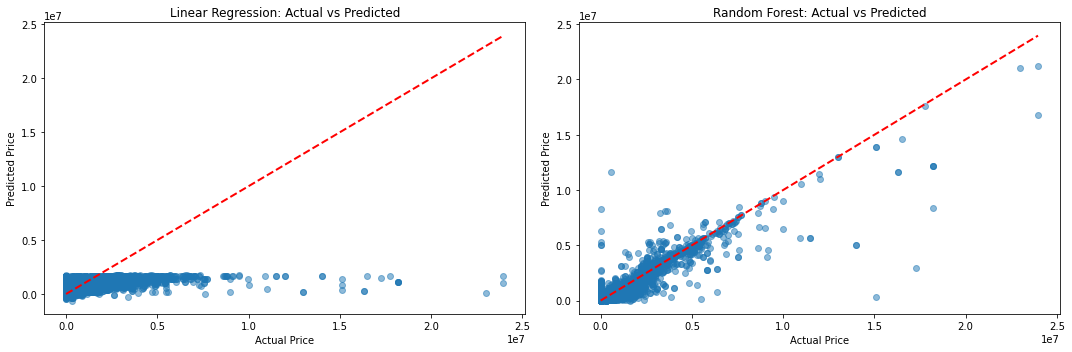

['scaler.joblib']

In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from datetime import datetime
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_features(df):
    """準備和清理特徵"""
    # 複製DataFrame以避免修改原始資料
    df = df.copy()
    
    # 1. 只保留我們確定要用的數值型特徵
    features_to_keep = [
        'ROOMS', 
        'BATHRM',
        'BEDRM',
        'LANDAREA', 
        'GBA',
        'PRICE',
        'Sale_Year', 
        'Sale_Month', 
        'Cluster'
    ]
    
    # 2. 只選擇要保留的特徵
    df = df[features_to_keep]
    
    # 3. 檢查並印出每個欄位的缺失值數量
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())
    
    # 4. 檢查每個欄位的數據類型
    print("\nData types before conversion:")
    print(df.dtypes)
    
    # 5. 確保所有特徵都是數值型的
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 6. 處理極端值
    # 使用 IQR 方法識別和處理極端值
    for col in df.columns:
        if col != 'PRICE' and col != 'Sale_Year' and col != 'Sale_Month' and col != 'Cluster':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower_bound, upper_bound)
    
    # 7. 處理缺失值
    # 對於數值型特徵，使用中位數填充
    for col in df.columns:
        if col != 'PRICE':  # 不處理目標變數
            df[col].fillna(df[col].median(), inplace=True)
    
    # 8. 再次確認是否還有缺失值
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())
    
    # 9. 建立一些基本的特徵組合
    df['Rooms_per_Area'] = df['ROOMS'] / df['GBA']
    df['Bathrooms_per_Room'] = df['BATHRM'] / df['ROOMS']
    df['Bedrooms_per_Room'] = df['BEDRM'] / df['ROOMS']
    
    # 10. 處理可能的無限值
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median())
    
    # 11. 最後確認所有數據都是數值型的
    print("\nFinal data types:")
    print(df.dtypes)
    
    # 12. 顯示基本統計信息
    print("\nBasic statistics of the features:")
    print(df.describe())
    
    return df

# 準備資料
print("Preparing features...")
cleaned_data = prepare_features(final_data)

# 分離特徵和目標變數
X = cleaned_data.drop(['PRICE'], axis=1)
y = cleaned_data['PRICE']

# 再次確認沒有 NaN 值
print("\nChecking for any remaining NaN values in features:")
print(X.isnull().sum().sum())
print("\nChecking for any remaining NaN values in target:")
print(y.isnull().sum())

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. 線性迴歸
print("\n=== Linear Regression Analysis ===")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 預測和評估
lr_pred_train = lr_model.predict(X_train_scaled)
lr_pred_test = lr_model.predict(X_test_scaled)

print("\nLinear Regression Results:")
print(f"Training R² Score: {r2_score(y_train, lr_pred_train):.4f}")
print(f"Testing R² Score: {r2_score(y_test, lr_pred_test):.4f}")
print(f"Training RMSE: ${np.sqrt(mean_squared_error(y_train, lr_pred_train)):,.2f}")
print(f"Testing RMSE: ${np.sqrt(mean_squared_error(y_test, lr_pred_test)):,.2f}")

# 特徵重要性（線性迴歸）
feature_importance_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_model.coef_)
})
feature_importance_lr = feature_importance_lr.sort_values('Importance', ascending=False)

print("\nTop Features (Linear Regression):")
print(feature_importance_lr)

# 2. 隨機森林
print("\n=== Random Forest Analysis ===")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 預測和評估
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)

print("\nRandom Forest Results:")
print(f"Training R² Score: {r2_score(y_train, rf_pred_train):.4f}")
print(f"Testing R² Score: {r2_score(y_test, rf_pred_test):.4f}")
print(f"Training RMSE: ${np.sqrt(mean_squared_error(y_train, rf_pred_train)):,.2f}")
print(f"Testing RMSE: ${np.sqrt(mean_squared_error(y_test, rf_pred_test)):,.2f}")

# 特徵重要性（隨機森林）
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance_rf = feature_importance_rf.sort_values('Importance', ascending=False)

print("\nTop Features (Random Forest):")
print(feature_importance_rf)

# 視覺化預測結果
plt.figure(figsize=(15, 5))

# 線性迴歸預測vs實際值
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')

# 隨機森林預測vs實際值
plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')

plt.tight_layout()
plt.show()

# 儲存模型
import joblib
joblib.dump(lr_model, 'linear_regression_model.joblib')
joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')  # 記得也要儲存 scaler

=== Model Performance Comparison ===

Linear Regression:
Training RMSE: $623,478.66
Testing RMSE: $637,272.61
Training R²: 0.2000
Testing R²: 0.1955

Random Forest:
Training RMSE: $125,533.70
Testing RMSE: $240,947.67
Training R²: 0.9676
Testing R²: 0.8850



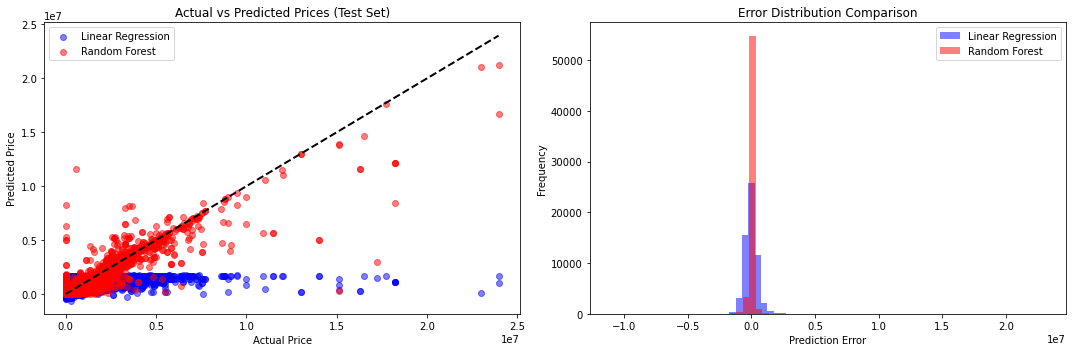

Linear Regression - Top 10 Important Features:
               Feature     Importance
1               BATHRM  568269.092333
9   Bathrooms_per_Room  278761.624582
0                ROOMS  159500.327893
5            Sale_Year  103292.222952
4                  GBA  103181.969870
7              Cluster   45125.125621
10   Bedrooms_per_Room   44722.271200
2                BEDRM   40005.608726
8       Rooms_per_Area   14451.494117
3             LANDAREA    7917.616055

Random Forest - Top 10 Important Features:
              Feature  Importance
7             Cluster    0.216541
1              BATHRM    0.176786
5           Sale_Year    0.146961
3            LANDAREA    0.122076
4                 GBA    0.086874
6          Sale_Month    0.085574
8      Rooms_per_Area    0.066959
10  Bedrooms_per_Room    0.031481
2               BEDRM    0.025972
0               ROOMS    0.021215


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_model_performance(X, y, test_size=0.2, random_state=42):
    """
    計算線性迴歸和隨機森林的性能指標
    """
    # 分割數據
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # 標準化特徵
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. 線性迴歸
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    lr_pred_train = lr_model.predict(X_train_scaled)
    lr_pred_test = lr_model.predict(X_test_scaled)
    
    # 2. 隨機森林
    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf_model.fit(X_train_scaled, y_train)
    rf_pred_train = rf_model.predict(X_train_scaled)
    rf_pred_test = rf_model.predict(X_test_scaled)
    
    # 計算性能指標
    results = {
        'Linear Regression': {
            'Train RMSE': np.sqrt(mean_squared_error(y_train, lr_pred_train)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, lr_pred_test)),
            'Train R²': r2_score(y_train, lr_pred_train),
            'Test R²': r2_score(y_test, lr_pred_test)
        },
        'Random Forest': {
            'Train RMSE': np.sqrt(mean_squared_error(y_train, rf_pred_train)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, rf_pred_test)),
            'Train R²': r2_score(y_train, rf_pred_train),
            'Test R²': r2_score(y_test, rf_pred_test)
        }
    }
    
    # 打印結果
    print("=== Model Performance Comparison ===\n")
    for model_name, metrics in results.items():
        print(f"{model_name}:")
        print(f"Training RMSE: ${metrics['Train RMSE']:,.2f}")
        print(f"Testing RMSE: ${metrics['Test RMSE']:,.2f}")
        print(f"Training R²: {metrics['Train R²']:.4f}")
        print(f"Testing R²: {metrics['Test R²']:.4f}")
        print()
    
    # 視覺化比較
    plt.figure(figsize=(15, 5))
    
    # 1. 測試集預測值比較
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, lr_pred_test, alpha=0.5, label='Linear Regression', color='blue')
    plt.scatter(y_test, rf_pred_test, alpha=0.5, label='Random Forest', color='red')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices (Test Set)')
    plt.legend()
    
    # 2. 預測誤差分布比較
    plt.subplot(1, 2, 2)
    lr_errors = y_test - lr_pred_test
    rf_errors = y_test - rf_pred_test
    
    plt.hist(lr_errors, bins=50, alpha=0.5, label='Linear Regression', color='blue')
    plt.hist(rf_errors, bins=50, alpha=0.5, label='Random Forest', color='red')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results, lr_model, rf_model, (X_test, y_test, lr_pred_test, rf_pred_test)

# 執行性能計算
# 假設 X 是特徵，y 是目標變數
results, lr_model, rf_model, test_data = calculate_model_performance(X, y)

# 如果你想看更詳細的特徵重要性分析：
def analyze_feature_importance(X, lr_model, rf_model):
    """
    分析和比較兩個模型的特徵重要性
    """
    # 線性迴歸係數
    lr_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(lr_model.coef_)
    }).sort_values('Importance', ascending=False)
    
    # 隨機森林特徵重要性
    rf_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Linear Regression - Top 10 Important Features:")
    print(lr_importance.head(10))
    print("\nRandom Forest - Top 10 Important Features:")
    print(rf_importance.head(10))
    
    return lr_importance, rf_importance

# 執行特徵重要性分析
lr_importance, rf_importance = analyze_feature_importance(X, lr_model, rf_model)

In [23]:
# Check the dataset structure and price column
print("=== Dataset Information ===")
print("\nShape:", final_data.shape)
print("\nColumns:")
for i, col in enumerate(final_data.columns):
    print(f"{i}: {col}")

print("\n=== Price Column Statistics ===")
if 'PRICE' in final_data.columns:
    print("\nPrice column stats:")
    print(final_data['PRICE'].describe())
    print("\nPrice column null values:", final_data['PRICE'].isnull().sum())
    print("\nPrice column sample (first 5 values):", final_data['PRICE'].head())
else:
    print("\nWarning: 'PRICE' column not found!")
    # Check for any column containing 'price' (case insensitive)
    price_cols = [col for col in final_data.columns if 'price' in col.lower()]
    if price_cols:
        print("Found similar columns:", price_cols)

# Check numerical columns
print("\n=== Numerical Columns ===")
numerical_cols = final_data.select_dtypes(include=[np.number]).columns
print("\nNumerical columns:", numerical_cols.tolist())

# Check for any missing values
print("\n=== Missing Values ===")
missing_values = final_data.isnull().sum()
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])

# Display a sample of the data
print("\n=== Data Sample ===")
print(final_data.head())

=== Dataset Information ===

Shape: (298348, 175)

Columns:
0: HEAT_0.0
1: HEAT_1.0
2: HEAT_2.0
3: HEAT_3.0
4: HEAT_4.0
5: HEAT_5.0
6: HEAT_6.0
7: HEAT_7.0
8: HEAT_8.0
9: HEAT_9.0
10: HEAT_10.0
11: HEAT_11.0
12: HEAT_12.0
13: HEAT_13.0
14: HEAT_nan
15: STYLE_0.0
16: STYLE_1.0
17: STYLE_2.0
18: STYLE_3.0
19: STYLE_4.0
20: STYLE_5.0
21: STYLE_6.0
22: STYLE_7.0
23: STYLE_8.0
24: STYLE_9.0
25: STYLE_10.0
26: STYLE_11.0
27: STYLE_12.0
28: STYLE_13.0
29: STYLE_14.0
30: STYLE_15.0
31: STYLE_94.0
32: STYLE_99.0
33: STYLE_nan
34: STRUCT_0.0
35: STRUCT_1.0
36: STRUCT_2.0
37: STRUCT_4.0
38: STRUCT_5.0
39: STRUCT_6.0
40: STRUCT_7.0
41: STRUCT_8.0
42: STRUCT_13.0
43: STRUCT_nan
44: GRADE_0.0
45: GRADE_1.0
46: GRADE_2.0
47: GRADE_3.0
48: GRADE_4.0
49: GRADE_5.0
50: GRADE_6.0
51: GRADE_7.0
52: GRADE_8.0
53: GRADE_9.0
54: GRADE_10.0
55: GRADE_11.0
56: GRADE_12.0
57: GRADE_nan
58: CNDTN_0.0
59: CNDTN_1.0
60: CNDTN_2.0
61: CNDTN_3.0
62: CNDTN_4.0
63: CNDTN_5.0
64: CNDTN_6.0
65: CNDTN_nan
66: EXTWALL_0.0

In [24]:
# Check original categorical values
print("=== Original Categorical Values ===")
print("\nHEAT categories:")
print(data['HEAT'].value_counts())

print("\nSTYLE categories:")
print(data['STYLE'].value_counts())

# Check numeric columns in original data
print("\n=== Original Numeric Columns ===")
numeric_cols = data.select_dtypes(include=[np.number]).columns
print(numeric_cols.tolist())

# Let's also see the PRICE column in original data
print("\n=== Original Price Statistics ===")
print(data['PRICE'].describe())

# Compare with encoded data
print("\n=== Encoded Price Statistics ===")
print(final_data['PRICE'].describe())

=== Original Categorical Values ===

HEAT categories:
13.0    39592
1.0     37476
7.0     27272
8.0      1997
3.0       200
6.0       175
11.0      121
5.0       118
2.0        82
4.0        69
0.0        45
10.0       34
9.0        28
12.0       18
Name: HEAT, dtype: int64

STYLE categories:
4.0     80980
7.0     10158
6.0      7204
1.0      4308
3.0      2542
5.0       697
10.0      394
14.0      308
15.0      282
9.0       147
2.0       100
0.0        57
13.0       18
12.0       13
8.0        12
11.0        3
99.0        3
94.0        1
Name: STYLE, dtype: int64

=== Original Numeric Columns ===
['BATHRM', 'HF_BATHRM', 'HEAT', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'OBJECTID']

=== Original Price Statistics ===
count    9.682700e+04
mean     4.885024e+05
std      7.227679e+05
min      0.000000e+00
25% 


=== Missing Values Check ===
BATHRM                   1807
ROOMS                       0
BEDRM                    1828
GBA                         0
LANDAREA                    0
PRICE                   12207
Property_Age               68
Years_Since_Remodel    133992
Building_Density            0
Bedroom_Room_Ratio          0
Sale_Year                   0
Sale_Month                  0
Cluster                     0
dtype: int64

Data shape after outlier removal: (248916, 13)

Training Linear Regression...

Training Random Forest...

=== Model Performance ===

Linear Regression:
Training RMSE: $387,723.56
Testing RMSE: $386,929.02
Training R²: 0.2614
Testing R²: 0.2651

Random Forest:
Training RMSE: $50,450.92
Testing RMSE: $131,389.76
Training R²: 0.9875
Testing R²: 0.9153

=== Random Forest Feature Importance ===
                Feature  Importance
0                BATHRM    0.153889
3                   GBA    0.131966
9             Sale_Year    0.131903
5          Property_Age    0.

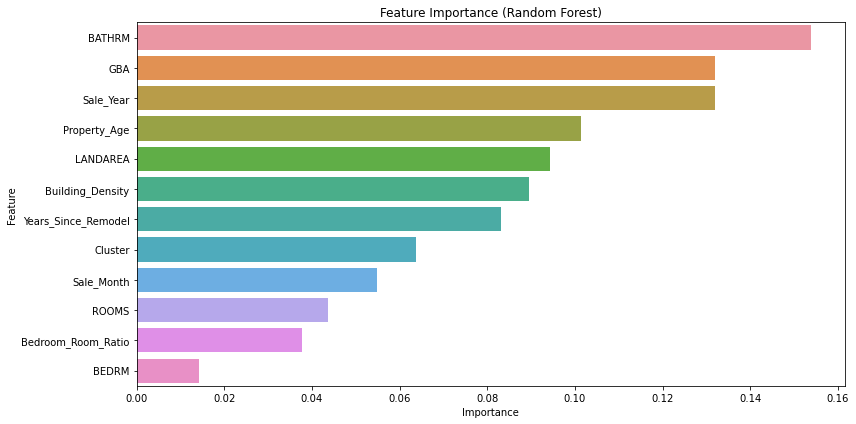

['scaler.joblib']

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Select important numeric features
numeric_features = [
    'BATHRM', 'ROOMS', 'BEDRM', 'GBA', 'LANDAREA', 
    'PRICE', 'Property_Age', 'Years_Since_Remodel',
    'Building_Density', 'Bedroom_Room_Ratio', 'Sale_Year', 
    'Sale_Month', 'Cluster'
]

# Create new dataframe with selected features
modeling_data = final_data[numeric_features].copy()

# Check for missing values
print("\n=== Missing Values Check ===")
print(modeling_data.isnull().sum())

# Handle missing values
modeling_data = modeling_data.fillna(modeling_data.median())

# Remove outliers using z-score
def remove_outliers(df, n_std=3):
    """Remove outliers using z-score method"""
    df_clean = df.copy()
    
    for column in df_clean.columns:
        if column != 'Cluster':  # Skip cluster column
            mean = df_clean[column].mean()
            std = df_clean[column].std()
            z_scores = np.abs((df_clean[column] - mean) / std)
            df_clean = df_clean[z_scores < n_std]
    
    return df_clean

# Remove outliers
modeling_data_clean = remove_outliers(modeling_data)
print(f"\nData shape after outlier removal: {modeling_data_clean.shape}")

# Split features and target
X = modeling_data_clean.drop('PRICE', axis=1)
y = modeling_data_clean['PRICE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Train Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

# Print results
print("\n=== Model Performance ===")
print("\nLinear Regression:")
print(f"Training RMSE: ${np.sqrt(mean_squared_error(y_train, lr_train_pred)):,.2f}")
print(f"Testing RMSE: ${np.sqrt(mean_squared_error(y_test, lr_test_pred)):,.2f}")
print(f"Training R²: {r2_score(y_train, lr_train_pred):.4f}")
print(f"Testing R²: {r2_score(y_test, lr_test_pred):.4f}")

print("\nRandom Forest:")
print(f"Training RMSE: ${np.sqrt(mean_squared_error(y_train, rf_train_pred)):,.2f}")
print(f"Testing RMSE: ${np.sqrt(mean_squared_error(y_test, rf_test_pred)):,.2f}")
print(f"Training R²: {r2_score(y_train, rf_train_pred):.4f}")
print(f"Testing R²: {r2_score(y_test, rf_test_pred):.4f}")

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\n=== Random Forest Feature Importance ===")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# Save models
import joblib
joblib.dump(lr_model, 'linear_regression_model.joblib')
joblib.dump(rf_model, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')